In [1]:
################################################
#### Code to create an example trajectory   ####
#### to make sure the code works correctly  ####
#### data for use in trajectory package     ####
#### By Ehsan Erfani   @UW on 17 Jan. 2022  ####
################################################

import datetime as dt
import numpy as np
import os
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import pandas as pd
from itertools import cycle
from geographiclib.geodesic import Geodesic
import time


from MERRA2.add_to_trajectory import add_MERRA_to_trajectory
from ERA5.add_to_trajectory import add_ERA_ens_to_trajectory, \
    add_ERA_sfc_to_trajectory, add_ERA_to_trajectory, add_advection_to_trajectory
from AMSR_Tb.add_to_trajectory import add_AMSR_Tb_to_trajectory
from CERES.add_to_trajectory import add_CERES_to_trajectory
from MODIS_pbl.add_to_trajectory import add_MODIS_pbl_to_trajectory
from SSMI.add_to_trajectory import add_SSMI_to_trajectory
from AMSR.add_to_trajectory import add_AMSR_to_trajectory

import utils
import config
import met_utils
import les_utils

all_datasets = ['ERA', 'ERA_sfc', 'ERA_ens', 'MODIS_pbl', 'MERRA', 'SSMI', 'CERES', 'AMSR_Tb', 'AMSR']


## Part 1: Create the Trajectory:

In [2]:
def rounder(values):
    def f(x):
        idx = np.argmin(np.abs(values - x))
        return values[idx]
    return np.frompyfunc(f, 1, 1)

def xarray_from_cset_flight_trajectory(rfnum, trajnum, trajectory_type='500m_+72'):
    tdump = utils.load_flight_trajectory(rfnum, trajnum, trajectory_type=trajectory_type)
    ds = xarray_from_tdump(tdump)
    global_attrs = [{'CSET_flight': rfnum},
        {'flight_trajectory': str(trajnum)}]
    for i in global_attrs:  # note: an OrderedDict would be tidier, but does not unpack in order
        ds = ds.assign_attrs(**i)
    return ds
    
def xarray_from_tdumpfile(tdumpfile):
    tdump = utils.read_tdump(tdumpfile).sort_values('dtime')
    ds = xarray_from_tdump(tdump)
    return ds
    

def xarray_from_tdump(tdump):
    ds = xr.Dataset.from_dataframe(tdump).drop(['tnum', 'gnum', 'age'])
    ds = ds.rename({'dtime': 'time'})
    # assigning global attributes
    global_attrs = [
        {'Title': "CSET Unified Trajectory Product"},
        {'institution': "Department of Atmospheric Sciences, University of Washington"},
        {'contact': "jkcm@uw.edu"},
        {'Creation Time': str(dt.datetime.utcnow())},
        {'trajectory_setup': "Trajectories were run isobarically " +
                            "from an initialization height of 500m " +
                            "for 72 hours, using GDAS analysis met data"},
        {'HYSPLIT_params': "Trajectories run using HYSPLIT (Hybrid Single "+
                   "Particle Lagrangian Integrated Trajectory Model). "+
                   "Acknowledgements to the NOAA Air Resources Laboratory "+
                   "(ARL) for the provision of the HYSPLIT transport and "+
                   "dispersion model used in this publication."},
        {'HYSPLIT_reference': "Stein, A.F., Draxler, R.R, Rolph, G.D., Stunder, "+
                      "B.J.B., Cohen, M.D., and Ngan, F., (2015). NOAA's "+
                      "HYSPLIT atmospheric transport and dispersion modeling "+ 
                      "system, Bull. Amer. Meteor. Soc., 96, 2059-2077, "+
                      "http://dx.doi.org/10.1175/BAMS-D-14-00110.1"}]
    for i in global_attrs:  # note: an OrderedDict would be tidier, but does not unpack in order
        ds = ds.assign_attrs(**i)
    
    # assigning variable attributes
    var_attrs = {
        'lon': {'long_name': 'longitude', 
                'units': 'degrees N'},
        'lat': {'long_name': 'latitude',
                'units': 'degrees E'},
        'fhour': {'long_name': 'forecast_lead_time',
                  'units': 'hours'},
        'pres': {'long_name':'trajectory_pressure',
                 'units': 'hPa'},
        'height': {'long_name': 'trajectory_height_above_ground',
                  'units': 'meters'}}
    for k,v in var_attrs.items():
        ds[k] = ds[k].assign_attrs(**v)
    ds.time.attrs['long_name'] = 'time'
    return ds

def save_trajectory_to_netcdf(ds, location):
    ds.to_netcdf(location)

def add_speeds_to_trajectories(ds):
    """Add speed variables to trajectory. used centered difference of distances traveled
    """
    lats, lons, times = ds.lat.values, ds.lon.values, ds.time.values
    
    heading_starts, heading_ends, seg_speeds = [], [], []
    
    for i in range(len(lats)-1):
        geod = Geodesic.WGS84.Inverse(lats[i], lons[i], lats[i+1], lons[i+1])
        dtime = (times[i+1]-times[i])/np.timedelta64(1, 's')
        heading_starts.append(geod['azi1'])
        heading_ends.append(geod['azi2'])
        seg_speeds.append(geod['s12']/dtime)

    #speeds are centered difference, except at start and end, where they are speeds of 
    #first and last trajectory segments
    #headings are average of end azimuth of previous segment/start azimuth of next geodesic segment,
    #except at start and end, where are just the start/end azimuths of the first/last geodesic
    speeds = np.mean(np.vstack([seg_speeds+[seg_speeds[-1]],[seg_speeds[0]]+seg_speeds]), axis=0)
     #headings = np.mean(np.vstack([[heading_starts[0]]+heading_ends, heading_starts+[heading_ends[-1]]]), axis=0) THIS HAD A BUG
    def radial_mean(h1, h2):
        diff = ((h2-h1)+180)%360-180
        return h1 + diff/2
    headings = radial_mean(np.array([heading_starts[0]]+heading_ends), np.array(heading_starts+[heading_ends[-1]]))
    
    u = speeds*np.cos(np.deg2rad(90-headings))
    v = speeds*np.sin(np.deg2rad(90-headings))
    
    ds['traj_u'] = (('time'), u, {'long_name': 'U component of trajectory velocity', 'units': "m s**-1"})
    ds['traj_v'] = (('time'), v, {'long_name': 'V component of trajectory velocity', 'units': "m s**-1"})
    ds['traj_hdg'] = (('time'), headings, {'long_name': 'Trajectory heading', 'units': 'deg'})
    ds['traj_spd'] = (('time'), speeds, {'long_name': 'Trajectory speed', 'units': "m s**-1"})
    return ds   



def make_trajectory(ds, skip=[], save=False):
    ds = add_speeds_to_trajectories(ds)
    if not 'ERA' in skip:
        print("adding ERA...")
        ds = add_ERA_to_trajectory(ds)
        print('adding advection...')
        ds = add_advection_to_trajectory(ds)
    if not 'ERA_sfc' in skip:
        print('adding ERA sfc data...')
        ds = add_ERA_sfc_to_trajectory(ds)
    if not 'ERA_ens' in skip:
        print('adding ERA ensemble data...')
        ds = add_ERA_ens_to_trajectory(ds)
    if not 'MODIS_pbl' in skip:
        print("adding MODIS...")
        ds = add_MODIS_pbl_to_trajectory(ds)
    if not 'MERRA' in skip:
        print("adding MERRA...")
        ds = add_MERRA_to_trajectory(ds)
    if not 'SSMI' in skip:
        print("adding SSMI...")
        ds = add_SSMI_to_trajectory(ds)
    if not 'CERES' in skip:
        print("adding CERES...")
        ds = add_CERES_to_trajectory(ds)
    if not 'AMSR_Tb' in skip:
        print("adding AMSR Tb...")
        ds = add_AMSR_Tb_to_trajectory(ds)
    if not 'AMSR' in skip:
        print("adding AMSR2...")
        ds = add_AMSR_to_trajectory(ds)
    if save:
        save_trajectory_to_netcdf(ds, save)
    return ds

def make_CSET_trajectory(rfnum, trajnum, save=False, trajectory_type='500m_+72', skip=[]):
    ds = xarray_from_cset_flight_trajectory(rfnum, trajnum, trajectory_type)
    ds = make_trajectory(ds, skip=skip, save=save)
    return ds
    
if __name__ == "__main__":

    
    force_override = True
    for case_num, case in config.all_cases.items():
        print('working on case {}'.format(case_num))
#         if case_num not in [6, 10]:
#             continue
        flight = case['TLC_name'].split("_")[1][:4].lower()
        traj_list = case['TLC_name'].split('_')[2].split('-')
        
        if case_num == 6 and flight == 'rf06':
        
            for dirn in ['forward', 'backward']:
                nc_dirstring = '48h_backward' if dirn == 'backward' else '72h_forward'
                #for traj in traj_list:
                for traj in ['2.3']:
    #                 if traj not in ['2.3', '6.0']:
    #                    continue
                    name = os.path.join(config.trajectory_netcdf_dir, "{}_{}_{}.nc".format(flight, nc_dirstring, traj))
                    print("working on {}...".format(os.path.basename(name)))
                    if os.path.exists(name):
                        print("already exists!")
                        if not force_override:
                            continue
                        else:
                            print('overriding')
                            os.rename(name, os.path.join(config.trajectory_netcdf_dir, 'old', "{}_{}_{}.nc".format(flight, nc_dirstring, traj)))
        #             ds = make_CSET_trajectory(rfnum=flight, trajnum=float(traj), save=name);
                    trajectory_type = '500m_-48' if dirn == 'backward' else '500m_+72'
                    print(name)
                    ds = make_CSET_trajectory(rfnum=flight, trajnum=float(traj), save=name, trajectory_type=trajectory_type, skip=['ERA_ens']);


    #ds = add_ERA_sfc_data(ds)
    #ds = make_CSET_trajectory(rfnum='rf06', trajnum=2.3, save=False)
    #save_trajectory_to_netcdf(ds, r'/home/disk/eos4/jkcm/Data/CSET/model_forcings/rf06_traj_2.3_fullcolumn_withz.nc')

#     all_trajs = {'rf06': [1.6, 2.0, 2.3, 2.6, 3.0],
#                  'rf10': [5.5, 6.0]}


    # for flight, traj_list in all_trajs.items():
    #     for traj in traj_list:
    #         name = os.path.join(config.trajectory_netcdf_dir, "{}_MODIS_traj_{:0.1f}.nc".format(flight, traj))
    #         print("working on {}...".format(os.path.basename(name)))
    #         ds = make_CSET_trajectory(rfnum=flight, trajnum=traj, save=name);


    # ds = make_CSET_trajectory(rfnum='rf06', trajnum=2.3, save=False)
    # save_trajectory_to_netcdf(ds, r'/home/disk/eos4/jkcm/Data/CSET/Lagrangian_project/trajectory_files/rf06_MODIS_traj_2.3.nc')


    # ds = make_CSET_trajectory(rfnum='rf10', trajnum=6.0, save=False)
    # save_trajectory_to_netcdf(ds, r'/home/disk/eos4/jkcm/Data/CSET/Lagrangian_project/trajectory_files/rf10_MODIS_traj_6.0.nc')

working on case 1
working on case 2
working on case 3
working on case 4
working on case 5
working on case 6
working on rf06_72h_forward_2.3.nc...
/home/disk/eos3/erfani/Data/CSET/Lagrangian_project/trajectory_files/rf06_72h_forward_2.3.nc
adding ERA...
prepping data...
creating gradient in MR...
done
working on cc...
100.00%      ETA 17:34:27      time left: 0 seconds        
working on z...
100.00%      ETA 17:34:27      time left: 0 seconds           
working on o3...
100.00%      ETA 17:34:28      time left: 0 seconds        
working on r...
100.00%      ETA 17:34:28      time left: 0 seconds        
working on clwc...
100.00%      ETA 17:34:29      time left: 0 seconds         
working on crwc...
100.00%      ETA 17:34:29      time left: 0 seconds        
working on t...
100.00%      ETA 17:34:30      time left: 0 seconds        
working on u...
100.00%      ETA 17:34:31      time left: 0 seconds        
working on v...
100.00%      ETA 17:34:31      time left: 0 seconds        
wo

In [3]:
import xarray as  xr
import numpy as np
import utils, met_utils, config
from config import CERES_fmt

In [5]:
config.CERES_fmt

'/home/disk/eos9/jkcm/Data/ceres/proc/split/CERES_SYN1deg-1H_Terra-Aqua-MODIS_Ed4.*.nc'

## Part 2: Create sample plots

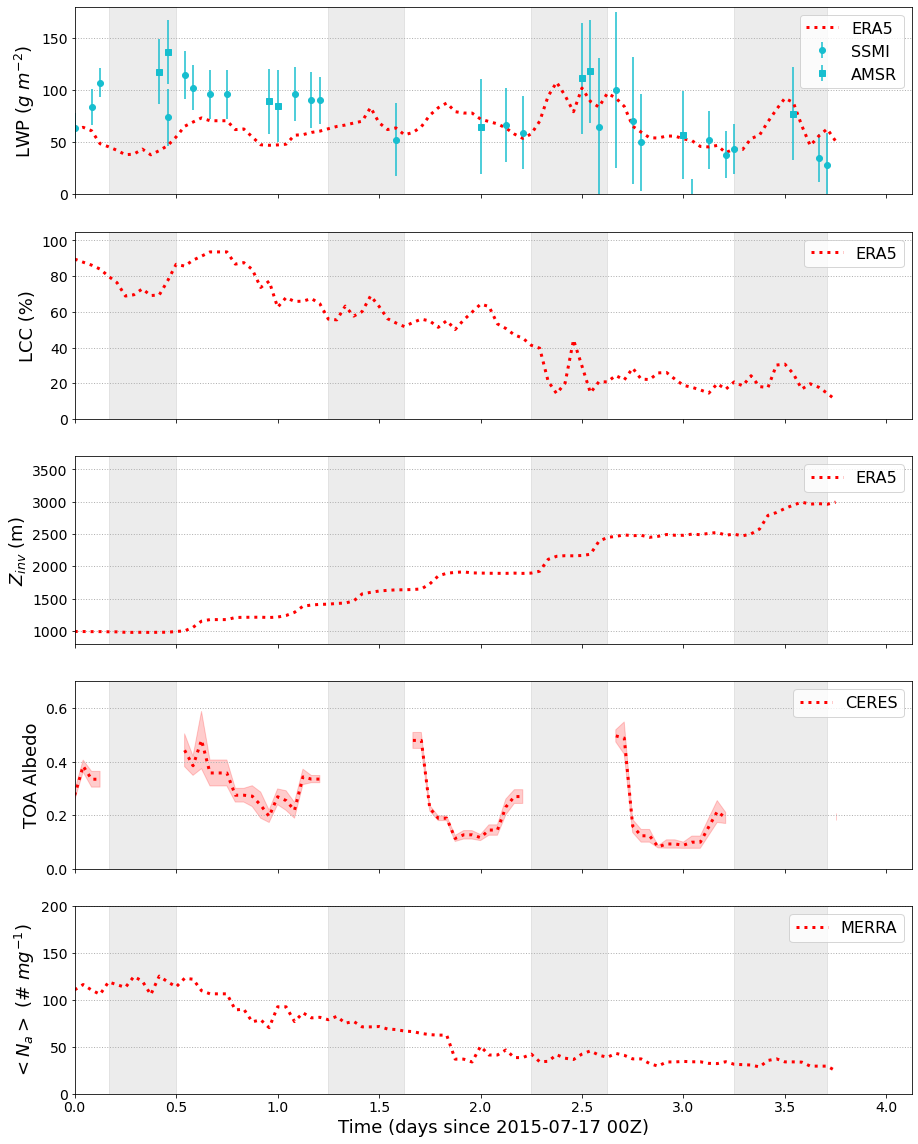

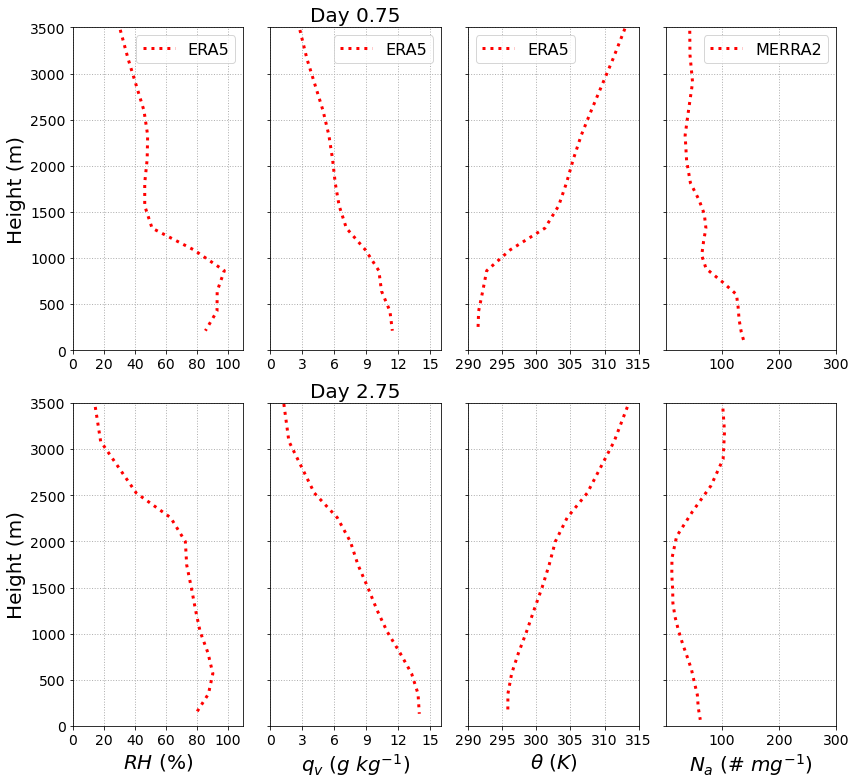

In [3]:
##### Required libraries
import numpy as np # linear algebra
import os
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
#import pandas as pd # data processing, CSV file
#from pandas import Series, DataFrame
from netCDF4 import Dataset
import warnings
warnings.filterwarnings("ignore")

##### read trajectory files
MERRA_data =Dataset('/home/disk/eos3/erfani/Data/CSET/Lagrangian_project/trajectory_files/rf06_72h_forward_2.3.nc')
MERRA_datab=Dataset('/home/disk/eos3/erfani/Data/CSET/Lagrangian_project/trajectory_files/rf06_48h_backward_2.3.nc')

#### Parameters
casename  = 'CSET-RF06-Tr2p3'
init_time = '2015-07-17 00Z' 
t_flight  = [0.75, 2.75]
Obs_jump  = 18
ylim      = 4000
t_flight = [0.75, 2.75]



###############################################################
### Calculate inversion height (min of dtheta/dz * dRH/dz)

## find delta after calculating mid-point values
def delta(THETA):
    nz = THETA.shape[1]
    THETAi = np.arange(THETA.shape[0] * (nz+1)).reshape(THETA.shape[0], nz+1).astype(float)
    THETAi[:] = np.nan
    THETAi[:,0] = 0
    THETAi[:,1:nz] = 0.5 * (THETA[:,:nz-1] + THETA[:,1:nz])
    THETAi[:,nz] = 1.5 * THETA[:,nz-1] - 0.5 * THETA[:,nz-2]
    d_THETA = THETAi[:,1:] - THETAi[:,:-1]
    return d_THETA

def inv_h(THETA, RH, dzz, zz):        
    d_THETA = THETA[:,1:] - THETA[:,:-1]
    d_RH = RH[:,1:] - RH[:,:-1]

    ZINV = d_THETA[:,0].copy()
    ZINV[:] = np.nan
    for i in range(d_THETA.shape[0]):
        z  = zz[i,:]  if len(zz.shape) > 1 else zz
        dz = dzz[i,:] if len(zz.shape) > 1 else dzz
        dTHETA_dz = d_THETA[i,:] / dz[1:]
        dRH_dz = d_RH[i,:] / dz[1:]
        dTHETA_dz[dTHETA_dz < 0] = 0
        dRH_dz[dRH_dz > 0] = 0    
        func = dTHETA_dz * dRH_dz
        if len(zz.shape) > 1:
            indx = np.max(np.where(func == np.nanmin(func))[0])
        else:
            indx = np.min(np.where(func == np.nanmin(func))[0])                    
        # approximate func as a parabola around the minimum and find the height where that parabola is minimized. 
        # This will allow the inversion height to vary continuously as the input profiles change.
        # inversion_test is defined at midpoints of grid
        zavg = 0.5 * (z[:-1] + z[1:])
        rnge = range(indx-1, indx+2)
        # we define the parabola, converting from m to km.
        pp = np.polyfit(1e-3 * zavg[rnge], func[rnge], 2)
        # take the derivative of the parabola in coeffient space.
        pp_prime = np.array([2 * pp[0], pp[1]]) # this is its derivative
        # find the zero-crossing of the derivative. This is the inversion height in meters
        z_inv = -1e3 * pp_prime[1] / pp_prime[0]         
        ZINV[i] = z_inv
    return ZINV

def mbl_ave_MERRA(MERRA_Na, ERA_ZINV, dz_MERRA):
    MERRA_Na_mean2 = MERRA_Na[:,0].copy()
    MERRA_Na_mean2[:] = np.nan
    for i in range(MERRA_Na_mean2.size):
        jjj = np.where(abs(MERRA_H[i,:] - ERA_ZINV[i]) == np.nanmin(abs(MERRA_H[i,:] - ERA_ZINV[i])))[0][0]
        MERRA_Na_mean2[i] = np.nansum(MERRA_RHO[i,jjj:] * MERRA_Na[i,jjj:] * dz_MERRA[i,jjj-1:])\
        / np.nansum(MERRA_RHO[i,jjj:] * dz_MERRA[i,jjj-1:])
    return MERRA_Na_mean2

## Find the index of model time when aircraft passes
def model_index(time, t_flight):
    iii = np.where(abs(time - t_flight) == np.nanmin(abs(time - t_flight)))[0][0]
    return iii


##############################################################################
### Read various satellite and reanalysis variables from trajectory files

## Concatenate a variable from forward and backward trajectories
def read_var_1D(var_name):
    var = np.concatenate( ( MERRA_datab.variables[var_name][(-Obs_jump+1):], \
                              MERRA_data.variables[var_name][:]), axis=0)
    return var

def read_var_2D(var_name):
    var = np.concatenate( ( MERRA_datab.variables[var_name][(-Obs_jump+1):,:], \
                              MERRA_data.variables[var_name][:]), axis=0)
    return var



### CERES
CERES_lwp     = read_var_1D('CERES_lwp_low_1h')       # Liquid Water Path - Low clouds: g/m2
CERES_cld     = read_var_1D('CERES_cldarea_low_1h')   # Cloud Area Fraction - Low clouds: %
CERES_t_sw    = read_var_1D('CERES_toa_sw_all_1h')    # Observed TOA Shortwave Flux - All-sky: w/m2
CERES_t_lw    = read_var_1D('CERES_toa_lw_all_1h')    # Observed TOA Longwave  Flux - All-sky: w/m2
CERES_t_si    = read_var_1D('CERES_toa_solar_all_1h') # Observed TOA Solar Insolation Flux - All-sky: w/m2
CERES_s_lwu   = read_var_1D('CERES_adj_atmos_lw_up_all_surface_1h')   # Adjusted All-Sky Profile Fluxes Longwave Flux Up - Surface: w/m2
CERES_s_lwd   = read_var_1D('CERES_adj_atmos_lw_down_all_surface_1h') # Adjusted All-Sky Profile Fluxes Longwave Flux Down - Surface: w/m2
CERES_s_swu   = read_var_1D('CERES_adj_atmos_sw_up_all_surface_1h')   # Adjusted All-Sky Profile Fluxes Shortgwave Flux Up - Surface: w/m2
CERES_s_swd   = read_var_1D('CERES_adj_atmos_sw_down_all_surface_1h') # Adjusted All-Sky Profile Fluxes Shortwave Flux Down - Surface: w/m2
CERES_sw_cre  = read_var_1D('CERES_sw_cre')   # Shortwave Cloud Radiative Effect 
CERES_lw_cre  = read_var_1D('CERES_lw_cre')   # Longwave Cloud Radiative Effect 
CERES_net_cre = read_var_1D('CERES_net_cre')  # Net Cloud Radiative Effect 
CERES_tau     = read_var_1D('CERES_cldtau_low_1h')    # Cloud Visible Optical Depth - Low clouds
CERES_re      = read_var_1D('CERES_cldwatrad_low_1h') # 

CERES_s_lw    = CERES_s_lwu - CERES_s_lwd
CERES_s_sw    = CERES_s_swd - CERES_s_swu
CERES_t_si2   = CERES_t_si.copy()
CERES_t_si2[CERES_t_si2 <= 100] = np.nan
CERES_albd    = (CERES_t_si2 - CERES_t_sw) / CERES_t_si2
CERES_albd2   = CERES_t_sw / CERES_t_si2
CERES_t_sw_std     = read_var_1D('CERES_toa_sw_all_1h_std')    # std of Observed TOA Shortwave Flux - All-sky: w/m2
CERES_t_sw_clr     = read_var_1D('CERES_toa_sw_clr_1h')        # Observed TOA Shortwave Flux - Clear-sky: w/m2
CERES_t_sw_clr_std = read_var_1D('CERES_toa_sw_clr_1h_std')    # std of Observed TOA Shortwave Flux - All-sky: w/m2

CERES_sw_cre_std  = abs(CERES_t_sw_std - CERES_t_sw_clr_std)
CERES_cld_std     = read_var_1D('CERES_cldarea_low_1h_std')   # std of Cloud Area Fraction - Low clouds: %
CERES_t_lw_std    = read_var_1D('CERES_toa_lw_all_1h_std')    # Observed TOA Longwave Flux - All-sky, , standard deviation over box: w/m2
CERES_toa_alb     = read_var_1D('CERES_toa_alb_all_1h')    
CERES_toa_alb_std = read_var_1D('CERES_toa_alb_all_1h_std')    

### SSMI
SSMI_WVP   = read_var_1D('SSMI_WVP')   # Columnar Water Vapor: mm
SSMI_lwp   = read_var_1D('SSMI_LWP')   # Cloud Liquid Water: mm
SSMI_WSPD  = read_var_1D('SSMI_WSPD')  # 10m Surface Wind Speed
SSMI_lwp_std = read_var_1D('SSMI_LWP_std')  # Cloud Liquid Water standard deviation over box: mm
AMSR_lwp   = read_var_1D('AMSR_LWP')   # Cloud Liquid Water: mm
AMSR_lwp_std = read_var_1D('AMSR_LWP_std')  # Cloud Liquid Water standard deviation over box: mm


### MERRA
MERRA_time2 = np.concatenate( ( (MERRA_datab.variables['time'][(-Obs_jump+1):] - MERRA_datab.variables['time'][-Obs_jump+1]) / 24, \
                              (MERRA_data.variables['time'][:] + Obs_jump) / 24), axis=0)
                                #time of measurement: seconds since 2015-07-17T17:00:00+00:00

MERRA_RHO       = read_var_2D('MERRA_AIRDENS')    # air_density: kg/m3                     
MERRA_Na        = read_var_2D('MERRA_Na_tot') / MERRA_RHO      # total aerosol from MERRA
MERRA_Na_corr   = read_var_2D('MERRA_Na_tot_corr') / MERRA_RHO # total aerosol number concentration, >100 um, corrected to aircraft
MERRA_H         = read_var_2D('MERRA_H')    # mid_layer_heights

dz_MERRA        = MERRA_H.copy()
dz_MERRA[:]     = np.nan
dz_MERRA[:,1:]  = MERRA_H[:,:-1] - MERRA_H[:,1:]
 
MERRA_H_mg, MERRA_time_mg = np.meshgrid(MERRA_H[0,:], MERRA_time2)    # making meshgrid


### AMSR
AMSR_prec     = read_var_1D('AMSR_prcp_mean') * 24 # AMSR Tb mean rain rate: converted to mm/day
AMSR_prcp_std = read_var_1D('AMSR_prcp_std') * 24  # AMSR Tb rain rate standard deviation: : converted to mm/day

AMSR_acc_R = AMSR_prec.copy()
AMSR_acc_R[:] = np.nan
for i in range(len(AMSR_acc_R)):
    AMSR_acc_R[i] = np.nansum(AMSR_prec[:i+1]) / (MERRA_time2[-1] * 24) 

### ERA
CTH_std  = read_var_1D('MODIS_CTH_std') * 1000   # MODIS cloud top height: converted to m
ERA_sshf = - read_var_1D('ERA_sshf')      # Instantaneous surface sensible heat flux: W/m2
ERA_slhf = - read_var_1D('ERA_slhf')      # Instantaneous surface sensible heat flux: W/m2
ERA_lcc  = read_var_1D('ERA_lcc') * 100   # Low cloud cover: convert to %
ERA_lev  = MERRA_data.variables['level'][:] # air_pressure: mb
ERA_z    = read_var_2D('ERA_z') / 10      # geopotential: converted from m**2 s**-2 to m
ERA_t    = read_var_2D('ERA_t')           # air_temperature: K
ERA_q    = read_var_2D('ERA_q') * 1000    # specific_humidity: converted to g/kg
ERA_r    = read_var_2D('ERA_r')           # relative_humidity: %
ERA_LTS  = read_var_1D('ERA_LTS')         # Lower Tropospheric Stability: K
ERA_cc   = read_var_2D('ERA_cc') * 100    # Fraction of cloud cover: converted to %
ERA_crwc = read_var_2D('ERA_crwc') * 1000 # Specific rain water content: converted to g kg**-1
ERA_clwc = read_var_2D('ERA_clwc') * 1000 # Specific cloud water content: converted to g kg**-1
ERA_wc   = ERA_crwc + ERA_clwc            # liquid water mixing ratio (rain water + liquid cloud water)
ERA_qt   = ERA_wc   + ERA_q

ERA_z_mg, ERA_time_mg = np.meshgrid(ERA_z[0,:], MERRA_time2) # making meshgrid
ERA_lev_mg, dummy = np.meshgrid(ERA_lev, MERRA_time2) # making meshgrid

# calculate ERA5 Theta:
Rd_cp = 0.286
ERA_THETA = ERA_t * (1000 / ERA_lev_mg) ** (Rd_cp)

MERRA_alt = np.nanmean(MERRA_H, 0)


## ERA5
Cp = 1005.7 # specific heat of dry air at constant pressure: J/kg/K
Lv = 2.5e6  # latent heat of vaporization: J/kg
ERA_THETAL = ERA_THETA - (ERA_THETA / ERA_t) * (Lv / Cp) * ERA_wc / 1000

##############################  
## Calc. ERA inversion height
#dz_ERA  = delta(ERA_z)
dz_ERA  = ERA_z.copy()
dz_ERA[:] = np.nan
dz_ERA[:,1:] = ERA_z[:,1:] - ERA_z[:,:-1]
ERA_ZINV= inv_h(ERA_THETAL, ERA_r, dz_ERA, ERA_z)

##Calculate the index of BL: find index where z is equal to ZINV
MERRA_inv_idx = np.arange(len(ERA_ZINV))
MERRA_inv_idx[:] = int(0)
for i in range(len(ERA_ZINV)):
    diff = abs(MERRA_H[i,:] - ERA_ZINV[i])
    MERRA_inv_idx[i] = np.where(diff == np.min(diff))[0][0]  

    
############################################
##### Calculate ERA5 water path
def ERA_LWP(var, ERA_z):
    delta_ERA_z = delta(ERA_z[:,::-1])[:,::-1]
    #delta_ERA_z = ERA_z[:,0:-1] - ERA_z[:,1:]
    ERA_lwp = var[:,0].copy()
    ERA_lwp[:] = np.nan
    ERA_RHO = var.copy()
    ERA_RHO[:] = np.nan
    for i in range(ERA_RHO.shape[0]):
        ERA_RHO[i,:] = np.interp(ERA_z[i,:], MERRA_H[i,:], MERRA_RHO[i,:])
    for i in range(delta_ERA_z.shape[0]):
        ERA_lwp[i] = np.nansum(var[i,:] * delta_ERA_z[i,:] * ERA_RHO[i,:]) # / np.nansum(delta_ERA_z2[i, :])
    return ERA_lwp

ERA_clwp = ERA_LWP(ERA_clwc, ERA_z)
ERA_crwp = ERA_LWP(ERA_crwc, ERA_z)


################ MERRA:
dz_MERRA = MERRA_H[:,:-1] - MERRA_H[:,1:]
MERRA_Na_mean      = mbl_ave_MERRA(MERRA_Na, ERA_ZINV, dz_MERRA)
MERRA_Na_corr_mean = mbl_ave_MERRA(MERRA_Na_corr, ERA_ZINV, dz_MERRA)



############################################
### Time series and vertical profiles
xlim = MERRA_time2[-1]

lngh = 10
box = 5
ERA_c = 'k'

upbound = MERRA_time2.copy()
upbound[:] = ylim
upbound[CERES_s_swd > 0] = np.nan


####
fig, axis = plt.subplots(5, 1,figsize=(15,20))

i = 0
axis[i].fill_between(MERRA_time2, -upbound, upbound, color='k', alpha=.075)
axis[i].plot(MERRA_time2, ERA_clwp + ERA_crwp, ':', linewidth= 3, color='r', label='ERA5')
axis[i].errorbar(MERRA_time2, SSMI_lwp * 1000, yerr=SSMI_lwp_std * 1000, color='tab:cyan', fmt='o', label='SSMI')
axis[i].errorbar(MERRA_time2, AMSR_lwp * 1000, yerr=AMSR_lwp_std * 1000, color='tab:cyan', fmt='s', label='AMSR')
axis[i].set_ylabel('LWP ($g$ $m^{-2}$)', fontsize = '18')
axis[i].set_ylim([0, 180])
axis[i].set_xlim([0, xlim + xlim / lngh])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
axis[i].legend(fontsize = '16')

i = 1
axis[i].fill_between(MERRA_time2, -upbound, upbound, color='k', alpha=.075)
obs1, = axis[i].plot(MERRA_time2, ERA_lcc, ':', linewidth= 3, color='r', label='ERA5')
axis[i].set_ylabel('LCC (%)', fontsize = '18')
axis[i].set_ylim([0, 105])
axis[i].set_xlim([0, xlim + xlim / lngh])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
axis[i].legend(fontsize = '16')

i = 2
axis[i].fill_between(MERRA_time2, -upbound, upbound, color='k', alpha=.075)
axis[i].plot(MERRA_time2, ERA_ZINV, ':', color='r', linewidth= 3, label='ERA5')
axis[i].legend(fontsize = '16')
axis[i].set_ylabel('$Z_{inv}$ (m)', fontsize = '18')
axis[i].set_xlim([0, xlim + xlim / lngh])
axis[i].set_ylim([800, 3700])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
axis[i].legend(fontsize = '16')
axis[i].axes.get_xaxis().set_ticklabels([])

i = 3
axis[i].fill_between(MERRA_time2, -upbound, upbound, color='k', alpha=.075)
axis[i].fill_between(MERRA_time2, CERES_toa_alb - CERES_toa_alb_std\
                     , CERES_toa_alb + CERES_toa_alb_std, color='r', alpha=0.2)
axis[i].plot(MERRA_time2, CERES_toa_alb, ':', linewidth= 3, color='r', label='CERES')
axis[i].set_ylabel('TOA Albedo', fontsize = '18')
axis[i].set_xlim([0, xlim + xlim / lngh])
axis[i].set_ylim([0, .7])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
axis[i].legend(fontsize = '16', loc='upper right')
axis[i].axes.get_xaxis().set_ticklabels([])

i = 4
axis[i].fill_between(MERRA_time2, -upbound, upbound, color='k', alpha=.075)
obs1, = axis[i].plot(MERRA_time2, MERRA_Na_corr_mean, ':', color='r', label='MERRA', linewidth=3)
axis[i].set_ylabel('$<N_a>$ (# $mg^{-1}$)', fontsize = '18')
axis[i].set_ylim([0, 200])
axis[i].set_xlim([0, xlim + xlim/lngh])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
axis[i].legend(fontsize = '16')#, loc='lower left')

plt.show()
#plt.savefig(casename+'_time_series_test.png' , format='png', dpi=200)
plt.close()


###########################
xx1 = 0
xx2 = 320
lngh =10
lw2 = ['3', '3', '3', '4.5', '3', '3']

upbound2D = [ylim] * 2
dnbound2D = [-ylim] * 2

####
fig, axis = plt.subplots(2, 4,figsize=(12,11))

for i in range(2):
    for j in range(4):
        
        #######        
        i_ERA = np.where( abs(t_flight[i] - MERRA_time2) == np.nanmin(abs(t_flight[i] - MERRA_time2)) )[0][0]
        iii_M = model_index(MERRA_time2, t_flight[i])

        if j == 0:
            if i == 1:
                axis[i,j].set_xlabel('$RH$ (%)', fontsize = '20')
            axis[i,j].set_xlim([0, 110])
            axis[i,j].set_xticks(range(0,120,20)) 
            
            cc50 = axis[i,j].plot(ERA_r[i_ERA,:], ERA_z[i_ERA,:], ':', c='r', label='ERA5', linewidth= 3)
            
        elif j == 1:
            if i == 1:
                axis[i,j].set_xlabel('$q_v$ ($g$ $kg^{-1}$)', fontsize = '20')#, horizontalalignment='right', x=.3)
            axis[i,j].set_xlim([0, 16])
            axis[i,j].set_xticks(range(0,18,3))
            
            cc60= axis[i,j].plot(ERA_qt[i_ERA,:], ERA_z[i_ERA,:], ':', c='r', label='ERA5', linewidth= 3) 
          
        elif j == 2:
            if i == 1:            
                axis[i,j].set_xlabel('$θ$ ($K$)', fontsize = '20')
            axis[i,j].set_xlim([290, 315])
            axis[i,j].set_xticks(range(290,320,5))
            
            cc70 = axis[i,j].plot(ERA_THETA[i_ERA,:], ERA_z[i_ERA,:], ':', c='r', label='ERA5', linewidth= 3)

        else:
            if i == 1:            
                axis[i,j].set_xlabel('$N_a$ (# $mg^{-1}$)', fontsize = '20')
            axis[i,j].set_xlim([1, 300])
            
            cc70 = axis[i,j].plot(MERRA_Na_corr[iii_M,:], MERRA_H[iii_M,:], ':', c='r', label='MERRA2', linewidth= 3)
            
        if j == 0:
            pass
        else:
            axis[i,j].axes.get_yaxis().set_ticklabels([])
        
        axis[i,j].set_ylim([0, 3500])
        axis[i,j].tick_params(axis='both', which='major', labelsize=14)
        axis[i,j].grid(linestyle=':', linewidth=1)                 
        

axis[0,1].set_title('Day {:.2f}'.format(t_flight[0]), fontsize = 20)
axis[1,1].set_title('Day {:.2f}'.format(t_flight[1]), fontsize = 20)
axis[0,0].set_ylabel('Height (m)', fontsize = '20')
axis[1,0].set_ylabel('Height (m)', fontsize = '20')
axis[0,0].legend(fontsize = '16', loc='upper right')
axis[0,1].legend(fontsize = '16', loc='upper right')
axis[0,2].legend(fontsize = '16', loc='upper left')
axis[0,3].legend(fontsize = '16', loc='upper right')
plt.tight_layout(w_pad=1)

plt.show()
#plt.savefig(casename+'_vert_profiles_test.png' , format='png', dpi=200)
plt.close()

## If the code is run correctly, your plots should match the ones provided below

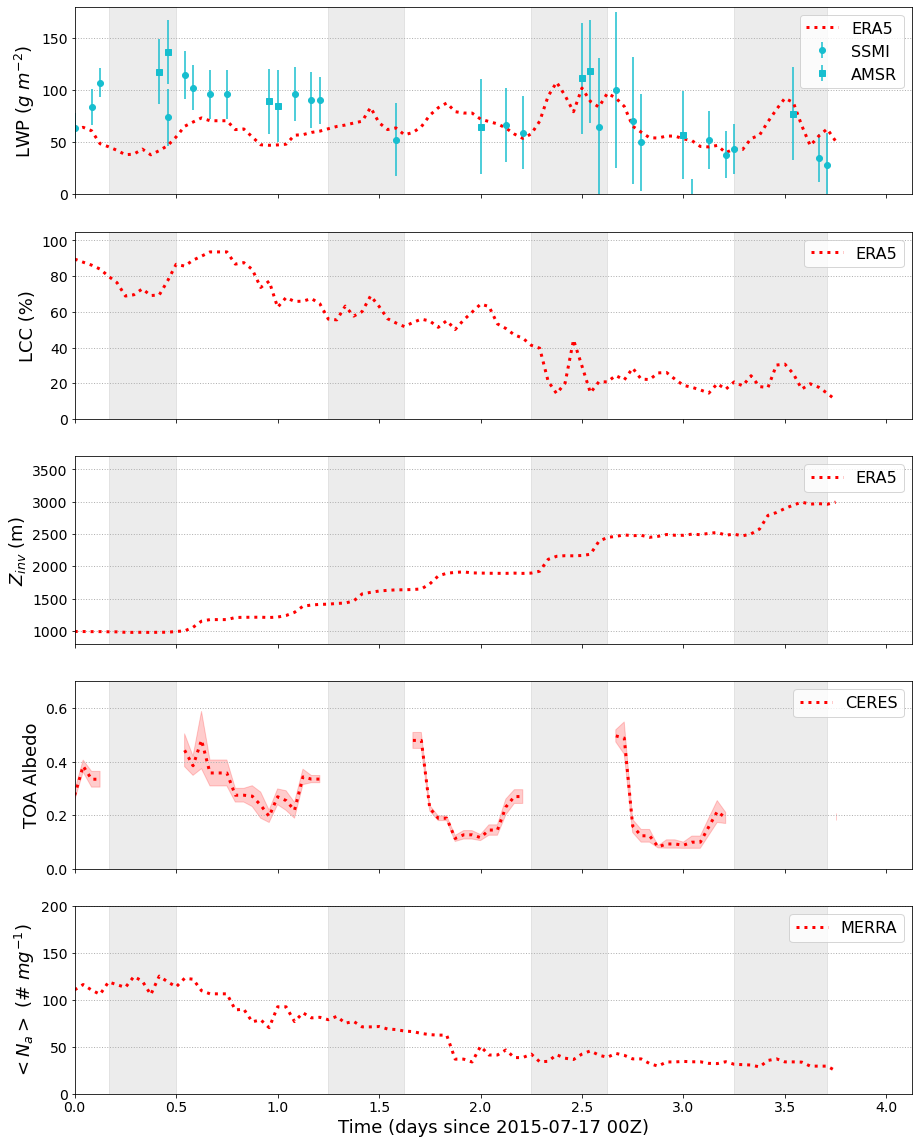

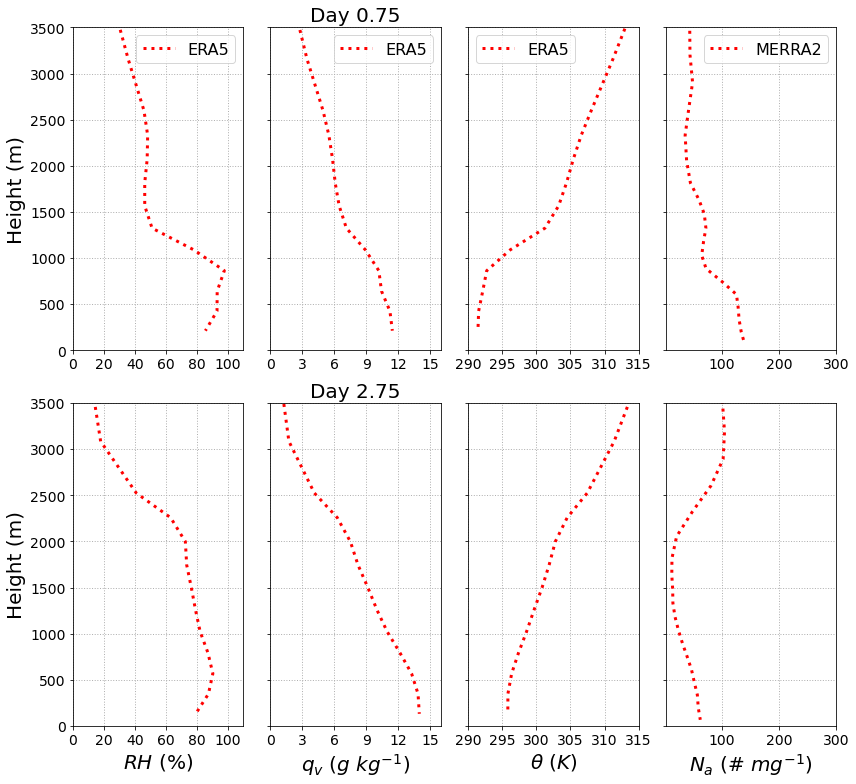